In [1]:
#import some needed libraries and required setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# dont print matching warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2', rc={'figure.figsize':(9,6), 'figure.dpi':90})

In [3]:
!pip install s3fs # Needed so that pandas can read and right to s3. pandas uses s3fs for handling S3 connections 
!pip install wordcloud # to generate word cloud
!pip install nltk
!pip install sklearn

  Using cached s3fs-0.5.1-py3-none-any.whl (21 kB)
  Using cached fsspec-0.8.4-py3-none-any.whl (91 kB)
  Using cached aiobotocore-1.1.2-py3-none-any.whl (45 kB)
     |████████████████████████████████| 1.3 MB 27.9 MB/s eta 0:00:01
  Using cached aioitertools-0.7.1-py3-none-any.whl (20 kB)
  Using cached botocore-1.17.44-py2.py3-none-any.whl (6.5 MB)
  Using cached async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
     |████████████████████████████████| 142 kB 83.1 MB/s eta 0:00:01
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
     |████████████████████████████████| 294 kB 79.5 MB/s eta 0:00:01
ERROR: boto3 1.16.19 has requirement botocore<1.20.0,>=1.19.19, but you'll have botocore 1.17.44 which is incompatible.
ERROR: awscli 1.18.179 has requirement botocore==1.19.19, but you'll have botocore 1.17.44 which is incompatible.
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.6.2
    Uninstalling fsspec-0.6.2:
      Successfully uninstalled fsspec-0.6

## Set Random Seed

In [2]:
seed = 500

In [4]:
input_path = 's3://osanusi-auto/preprocessed_frl_fake.csv'

## Loading the Dataset

In [5]:
# Import the data
df = pd.read_csv(input_path)
df.head()

,domain,content,scraped_at,title,label,day_name
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788000 entries, 0 to 1787999
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   domain      object
 1   content     object
 2   scraped_at  object
 3   title       object
 4   label       object
 5   day_name    object
dtypes: object(6)
memory usage: 81.8+ MB


In [7]:
# checking missing values
def missing_value(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missing_value

In [8]:
missing_value(df)

,Total,Percent
title,12629,0.706320
content,18,0.001007
day_name,0,0.000000
label,0,0.000000
scraped_at,0,0.000000
domain,0,0.000000


In [9]:
df.dropna(inplace=True)
missing_value(df)

,Total,Percent
day_name,0,0.0
label,0,0.0
title,0,0.0
scraped_at,0,0.0
content,0,0.0
domain,0,0.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1775353 entries, 0 to 1787999
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   domain      object
 1   content     object
 2   scraped_at  object
 3   title       object
 4   label       object
 5   day_name    object
dtypes: object(6)
memory usage: 94.8+ MB


## Distribution of the label variable

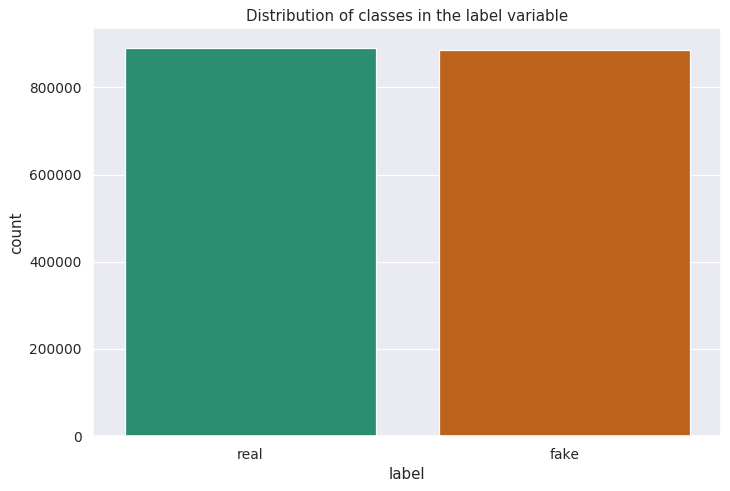

In [11]:
sns.countplot(x='label', data=df).set_title('Distribution of classes in the label variable');

## Unique domain counts

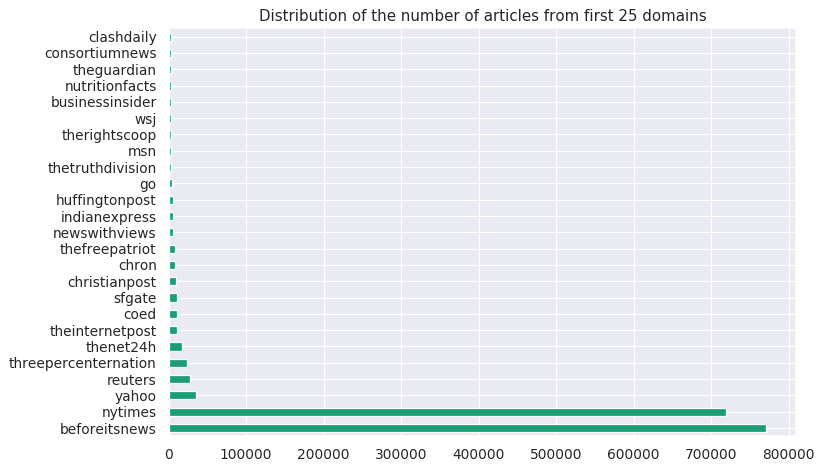

In [12]:
# plot of top 25 domains in the dataset
df.domain.value_counts(ascending=False).head(25).plot.barh(title='Distribution of the number of articles from first 25 domains')

##  Distribution of domains in each target variable

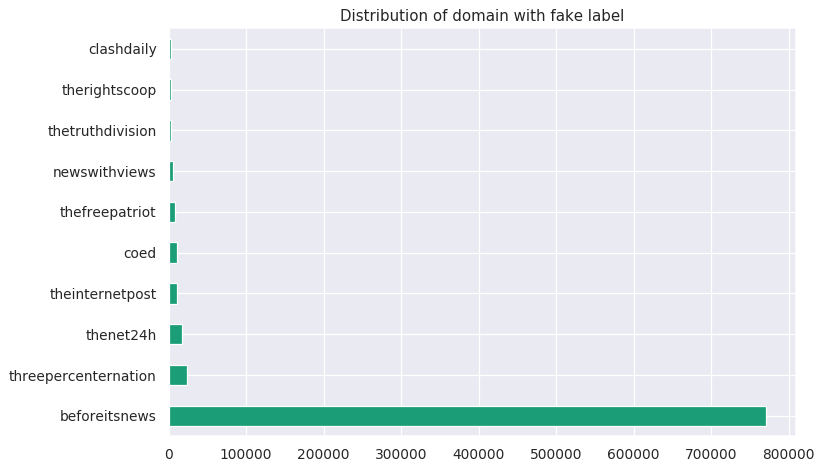

In [13]:
# Class fake
f_df = df[df['label']=='fake']
f_df['domain'].value_counts(ascending=False).head(10).plot.barh(title='Distribution of domain with fake label');

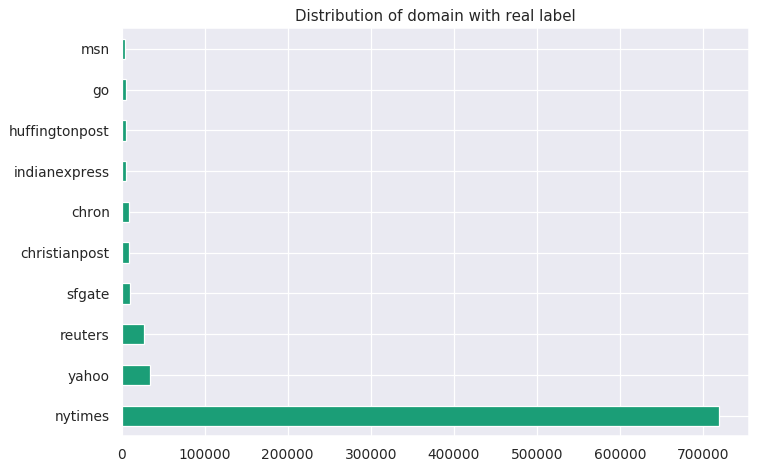

In [14]:
#class real
r_df = df[df['label']=='real']
r_df['domain'].value_counts(ascending=False).head(10).plot.barh(title='Distribution of domain with real label');



In [15]:
del f_df
del r_df

##  Unique count of days of the week

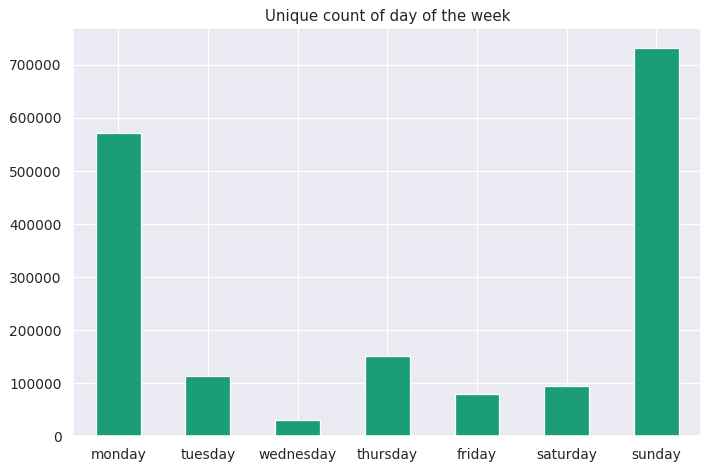

In [16]:
#Convert day_name columns to Ordered Categorical
cats = ['monday','tuesday','wednesday','thursday','friday','saturday', 'sunday']
df['day_name'] = pd.Categorical(df['day_name'], categories=cats,ordered=True)
#count the unique values
count_of_days = df['day_name'].value_counts()
#reset the index
count_of_days = count_of_days.sort_index()
count_of_days.plot.bar(rot=0,title='Unique count of day of the week');

## Explore fundamental characteristics of text in the title and content columns

### Frequencies of words

**The `counter` function from the `collections` library will be used to count and store the occurrences of each word in a list of tuples. This is a very useful function when we deal with word-level analysis in natural language processing**

In [17]:
from nltk.corpus import stopwords
from collections import Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:20]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)


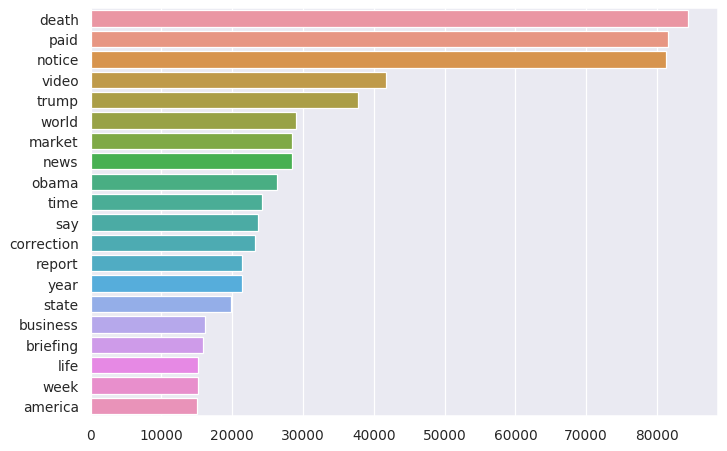

In [18]:
# plot of words in the title
plot_top_non_stopwords_barchart(df['title']);

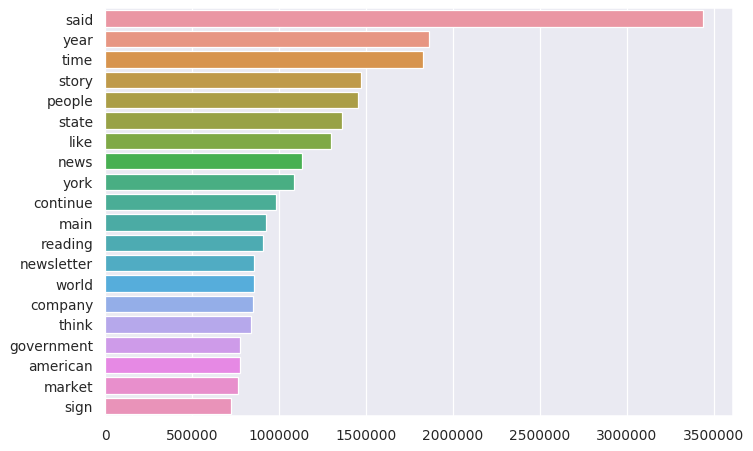

In [19]:
#plot of words in the content
plot_top_non_stopwords_barchart(df['content']);

### Count of characters

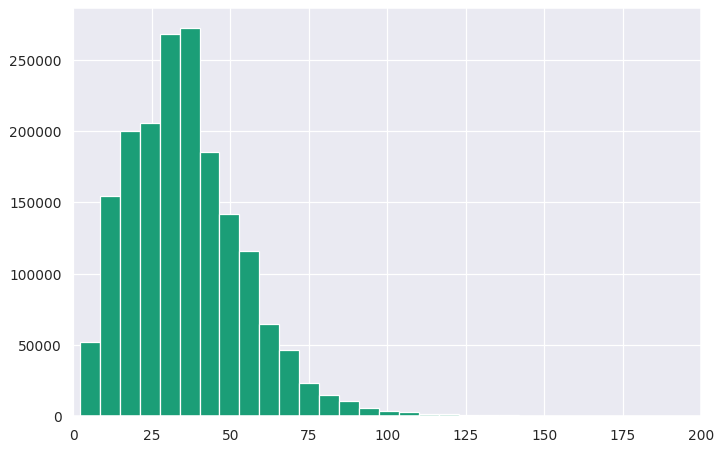

In [43]:
# Histogram plot of characters in the each title
df['title'].str.len().hist(bins=500) # this also includes spaces
plt.xlim((0, 200));

The histogram reveals that the title range from 0 to 100 characters and that majority of the title text has between 20 to 40 characters

(0, 12000)

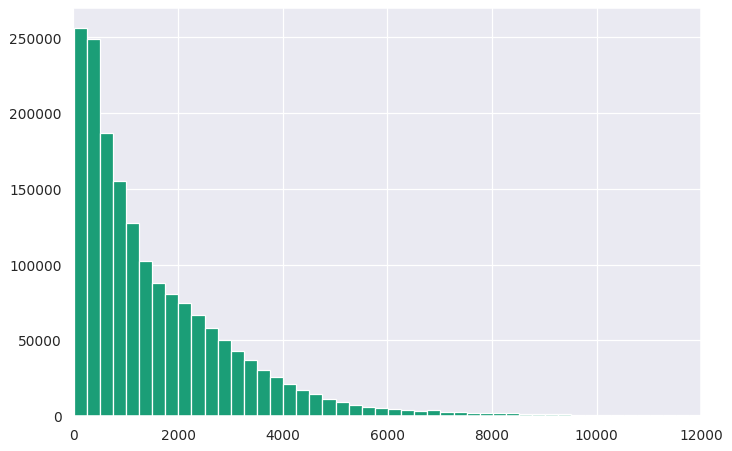

In [44]:
# Histogram plot of characters present in content row. This can give us a rough idea about the content length
df['content'].str.len().hist(bins=500)
plt.xlim((0,12000))

#### Number of characters in the title grouped by label

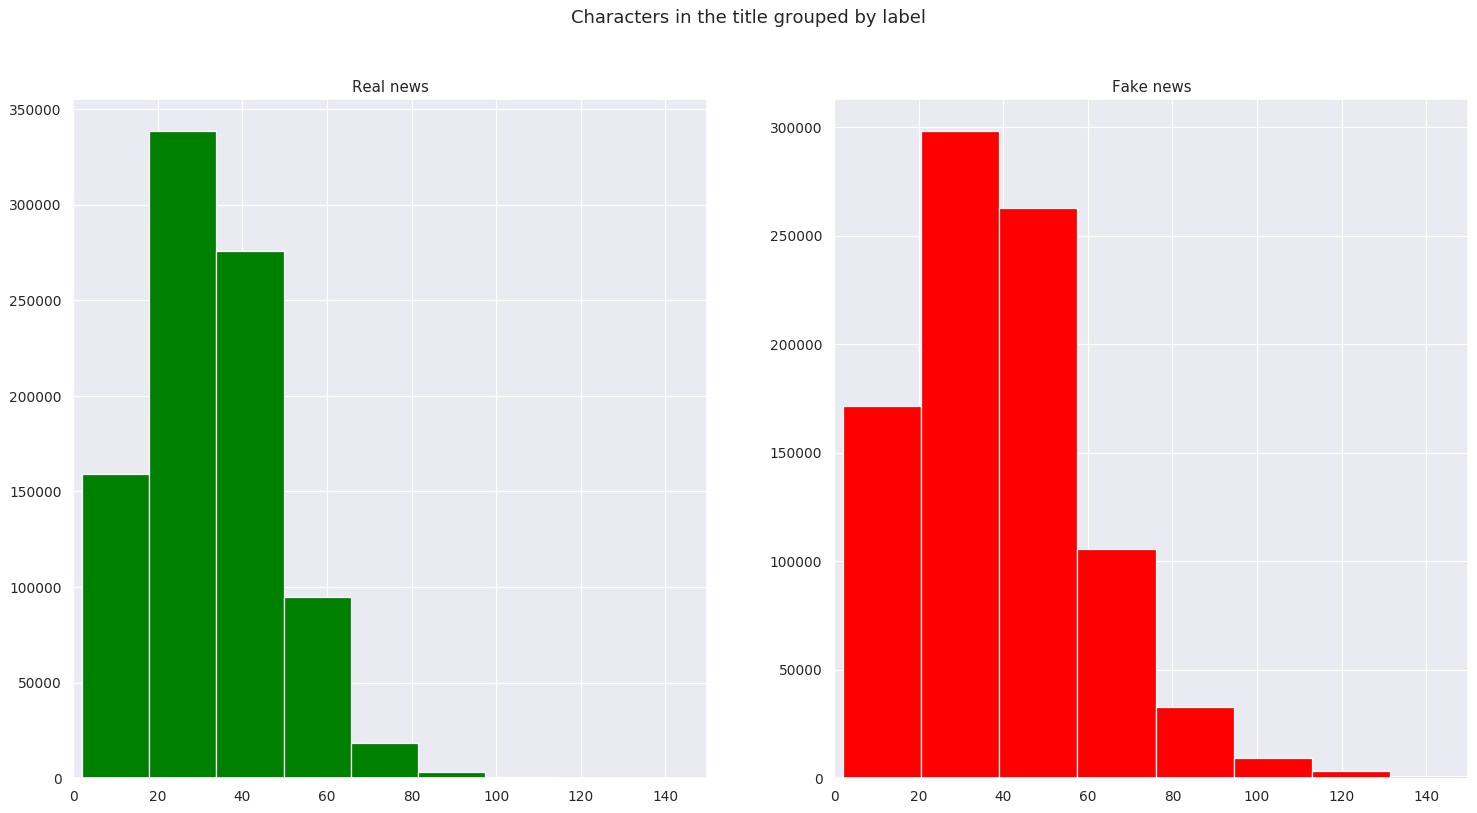

In [71]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
text_len=df[df['label']=='real']['title'].str.len()
ax1.hist(text_len, bins=200, color='green')
ax1.set_title('Real news')
ax1.set_xlim((0,150))
text_len=df[df['label']=='fake']['title'].str.len()
ax2.hist(text_len, bins=10, color='red')
ax2.set_title('Fake news')
ax2.set_xlim((0,150))
fig.suptitle('Characters in the title grouped by label')
plt.show()

#### Number of characters in the content grouped by label

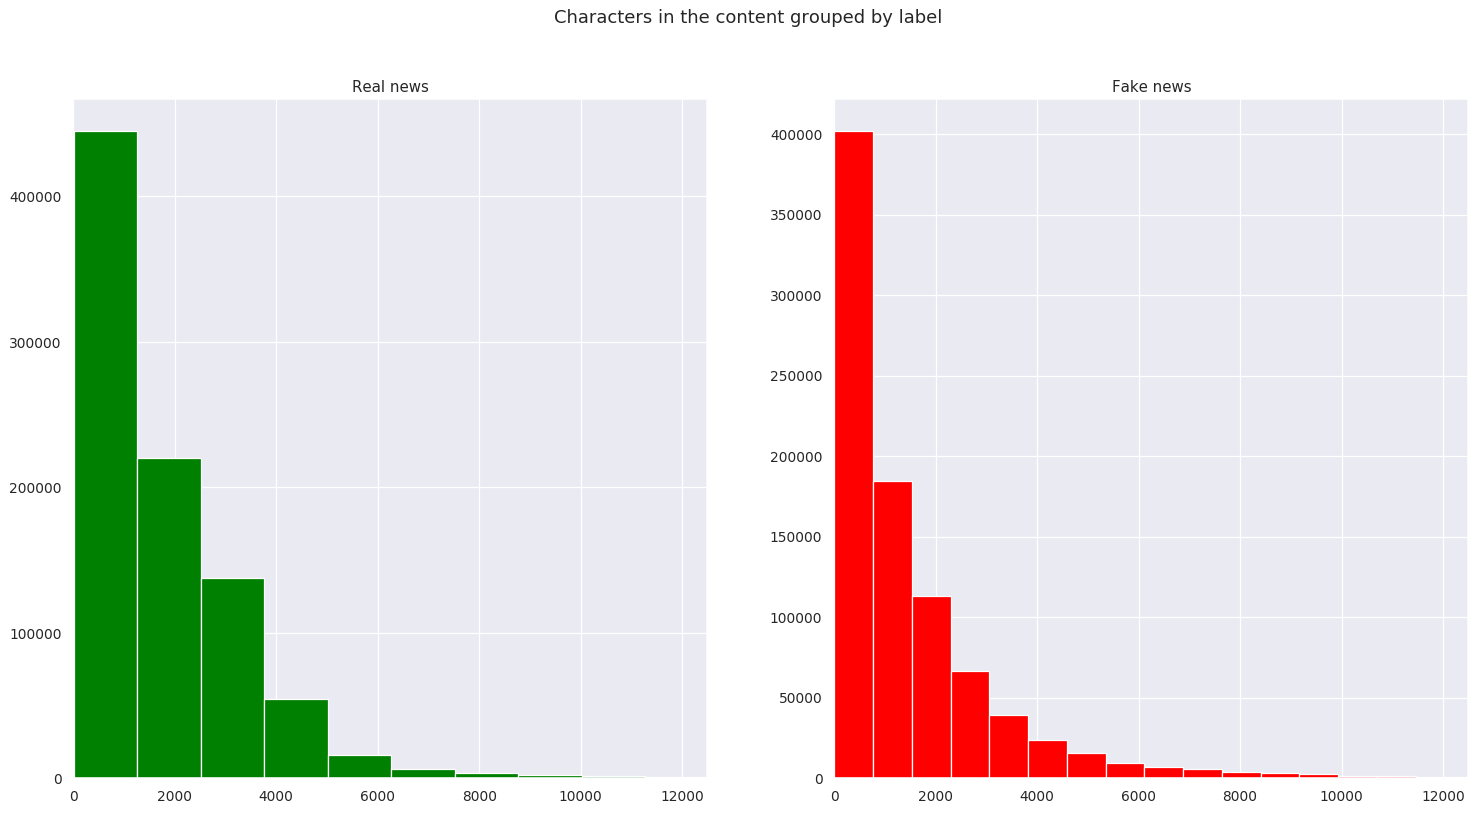

In [57]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
text_len=df[df['label']=='real']['content'].str.len()
ax1.hist(text_len, bins=100, color='green')
ax1.set_title('Real news')
ax1.set_xlim((0,12500))
text_len=df[df['label']=='fake']['content'].str.len()
ax2.hist(text_len, bins=100, color='red')
ax2.set_title('Fake news')
fig.suptitle('Characters in the content grouped by label')
ax2.set_xlim((0,12500))
plt.show()

### Number of words count

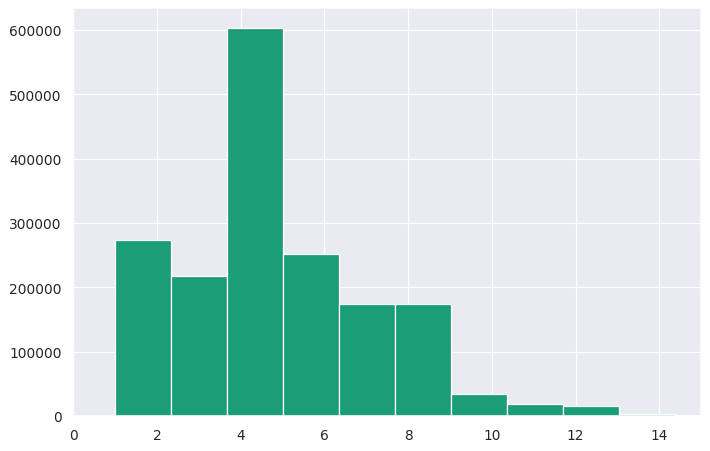

In [64]:
# Histogram plot of words count in the title
#df['title'].str.split().map(lambda x: len(x)).hist(); # Using .map
df['title'].apply(lambda x : len(str(x).split(" "))).hist(bins=300) # Using .apply
plt.xlim((0,15));

The number of words in the title ranges from 1 to 13 and mostly falls 4 words

In [72]:
# The total number of words in the title 
df['title'].apply(lambda x: len(x.split(' '))).sum()

8954606

(0, 1200)

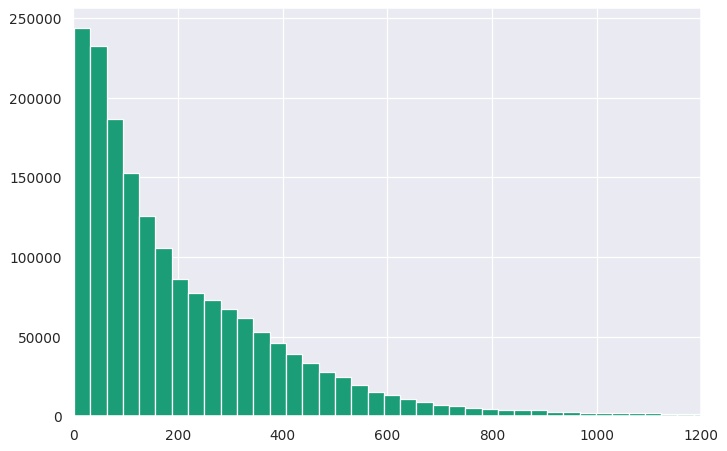

In [76]:
# Histogram plot of words count in the content
#df['content'].str.split().map(lambda x: len(x)).hist(); # Using .map
df['content'].apply(lambda x : len(str(x).split(" "))).hist(bins=500) # Using .apply
plt.xlim((0,1200))

In [77]:
# The total number of words in the content 
df['content'].apply(lambda x: len(x.split(' '))).sum()

392227179

#### Number of words in the title  grouped by label

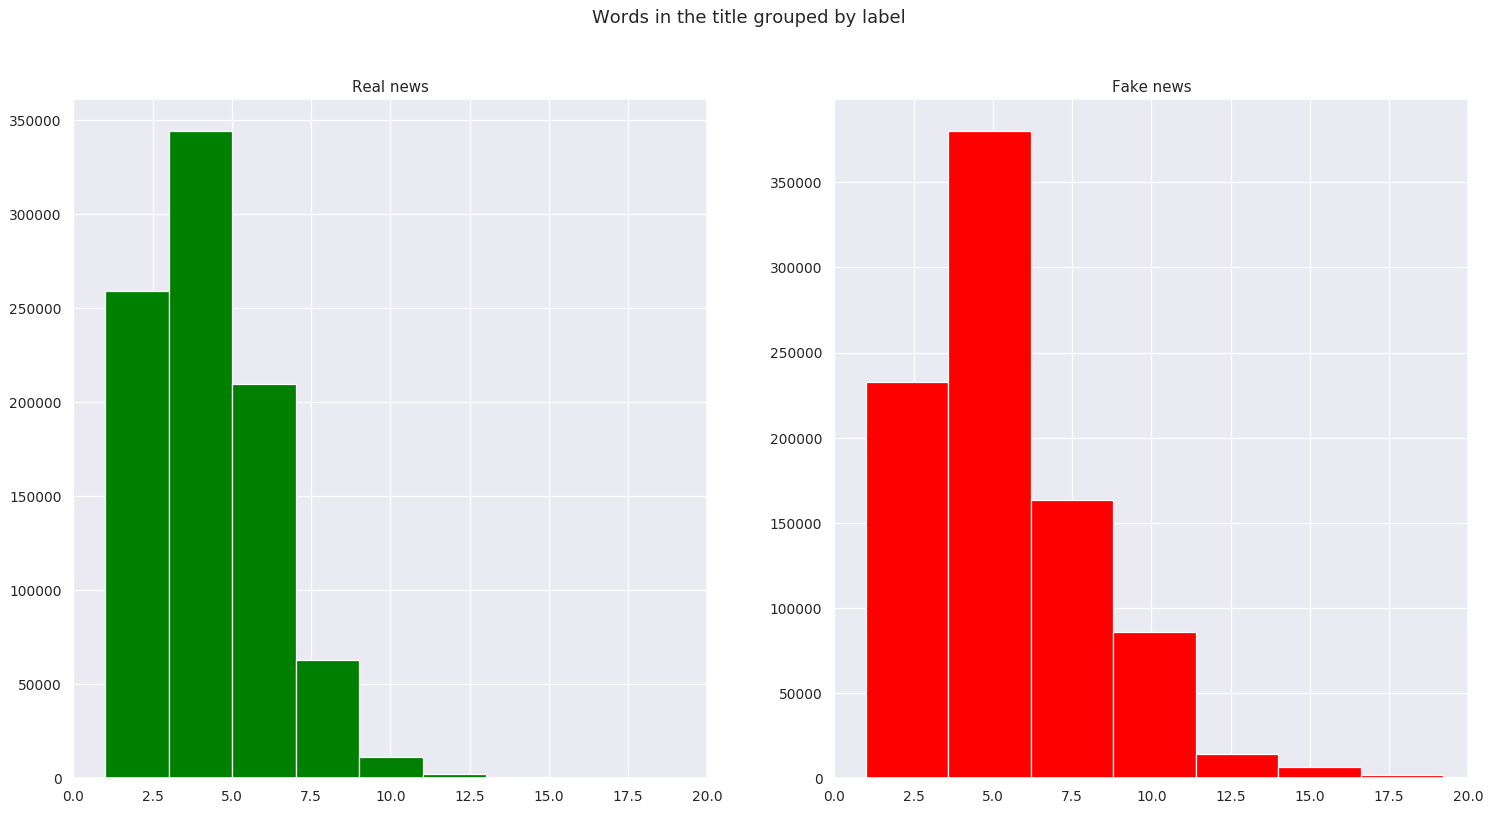

In [81]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
text_len=df[df['label']=='real']['title'].str.split().map(lambda x: len(x))
ax1.hist(text_len, bins=200, color='green')
ax1.set_title('Real news')
ax1.set_xlim((0,20))
text_len=df[df['label']=='fake']['title'].str.split().map(lambda x: len(x))
ax2.hist(text_len, bins=10, color='red')
ax2.set_title('Fake news')
ax2.set_xlim((0,20))
fig.suptitle('Words in the title grouped by label')
plt.show()

#### Number of words in the content  grouped by label

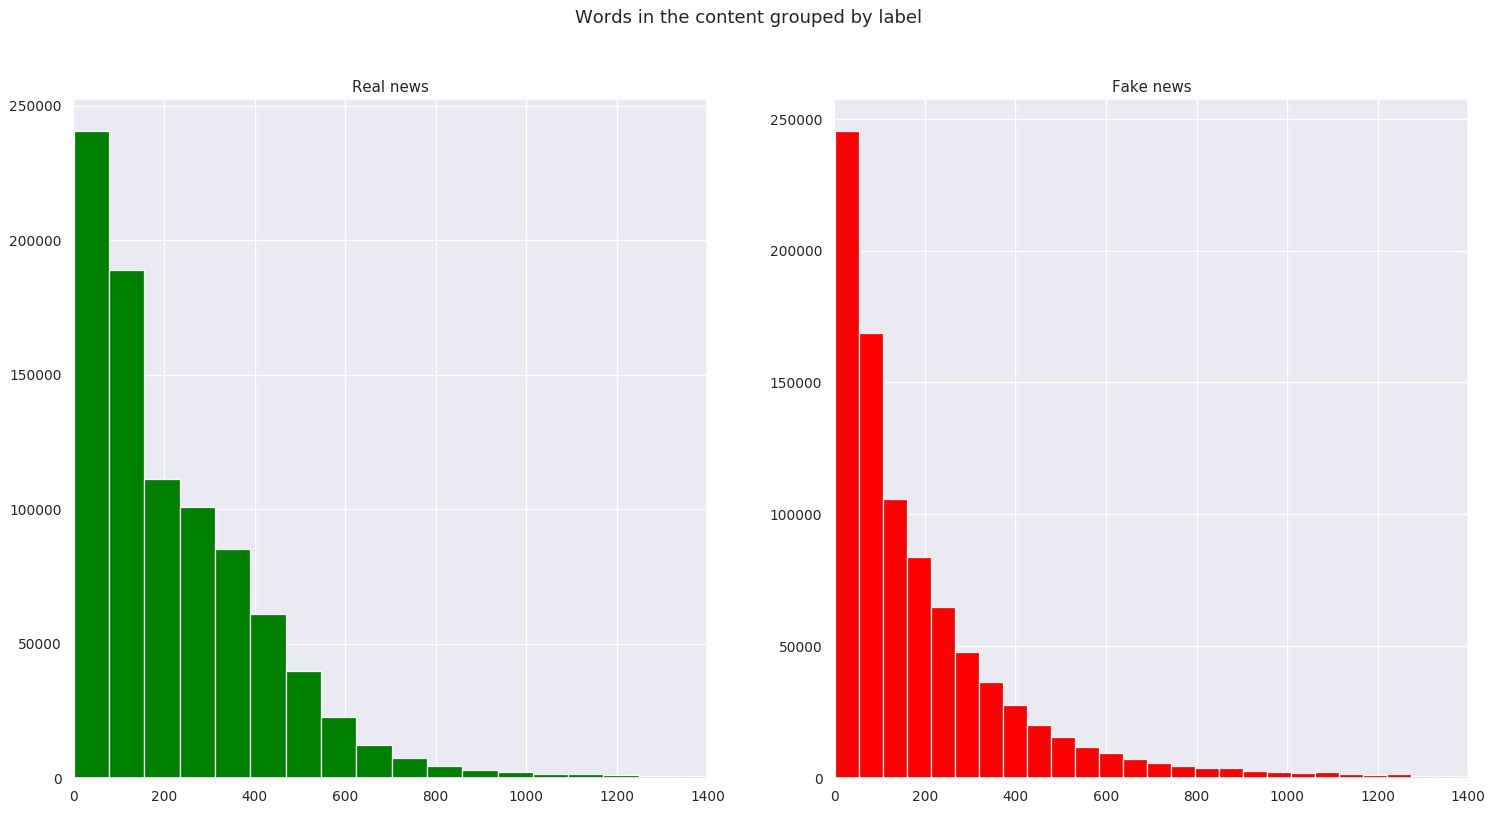

In [85]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
text_len=df[df['label']=='real']['content'].str.split().map(lambda x: len(x))
ax1.hist(text_len, bins=200, color='green')
ax1.set_title('Real news')
ax1.set_xlim((0,1400))
text_len=df[df['label']=='fake']['content'].str.split().map(lambda x: len(x))
ax2.hist(text_len, bins=200, color='red')
ax2.set_title('Fake news')
ax2.set_xlim((0,1400))
fig.suptitle('Words in the content grouped by label')
plt.show()

### Average word length 

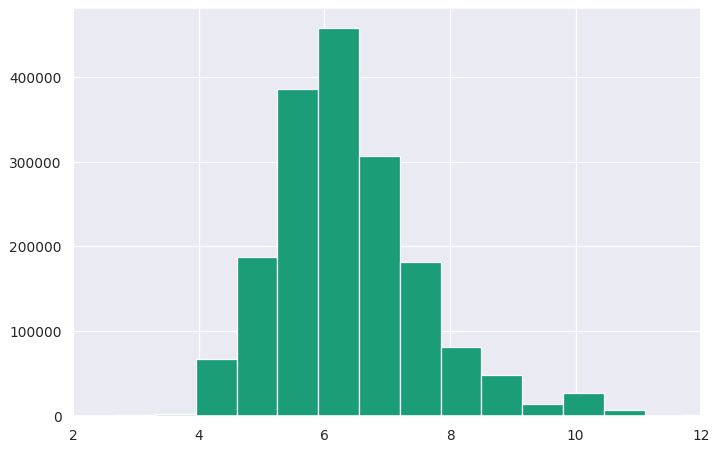

In [90]:
#Histogram of average number of words in the title
df['title'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(bins=20)
plt.xlim((2,12));

Average word range from 4 to 11 words. However, the most common is 6 words

In [1]:
#Histogram of average number of words in the content
df['content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(bins=50)
plt.xlim((4,9));

NameError: name 'df' is not defined

#### Average word length in the title  grouped by label

Text(0.5, 0.98, 'Average word length in each title')

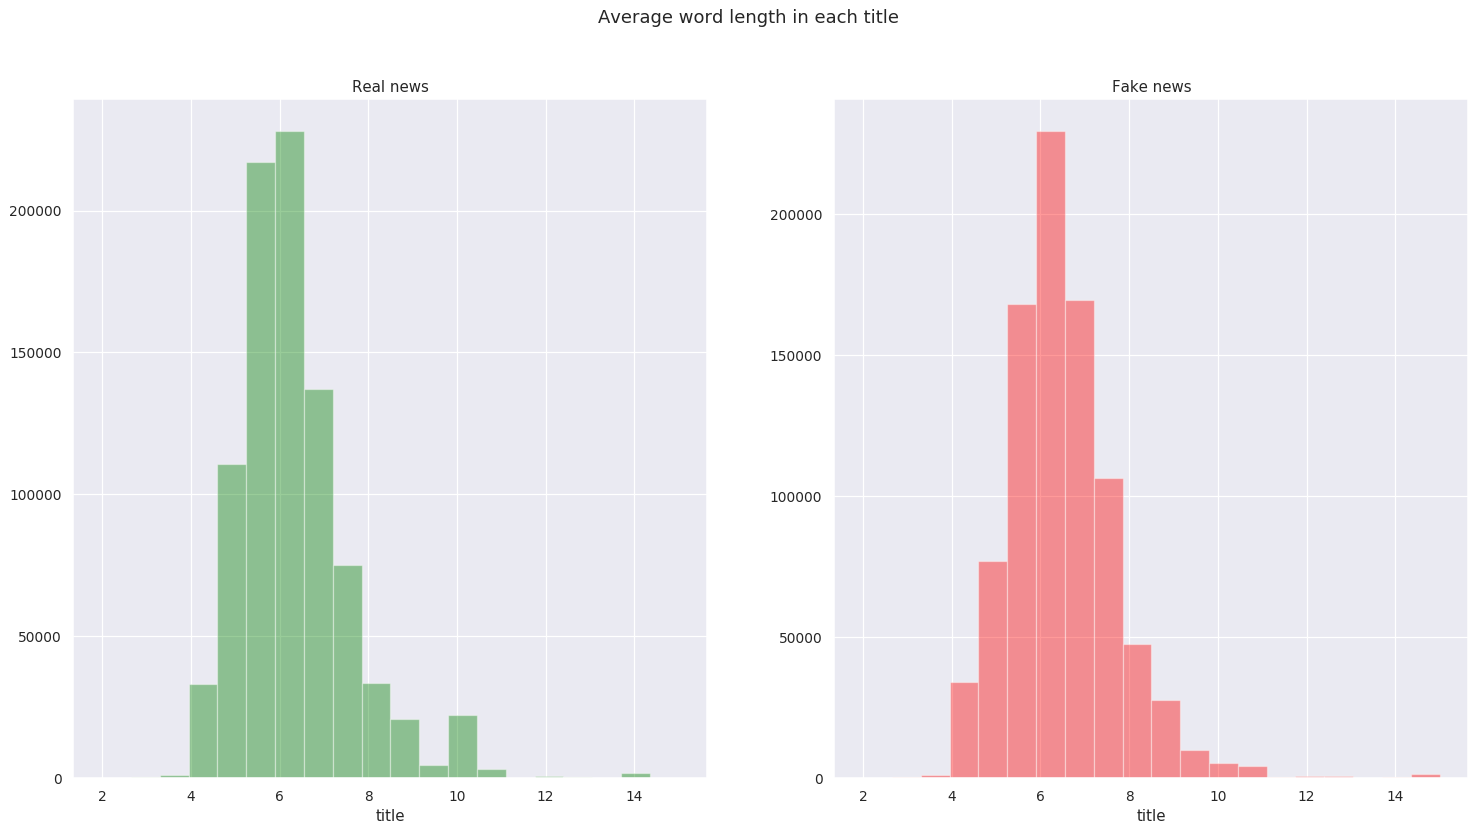

In [96]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['label']=='real']['title'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1, bins=20, kde=False, color='green')
ax1.set_title('Real news')
word=df[df['label']=='fake']['title'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2, bins=20, kde=False, color='red')
ax2.set_title('Fake news')
fig.suptitle('Average word length in each title')

#### Average word length in the content  grouped by label

Text(0.5, 0.98, 'Average word length in each row of content')

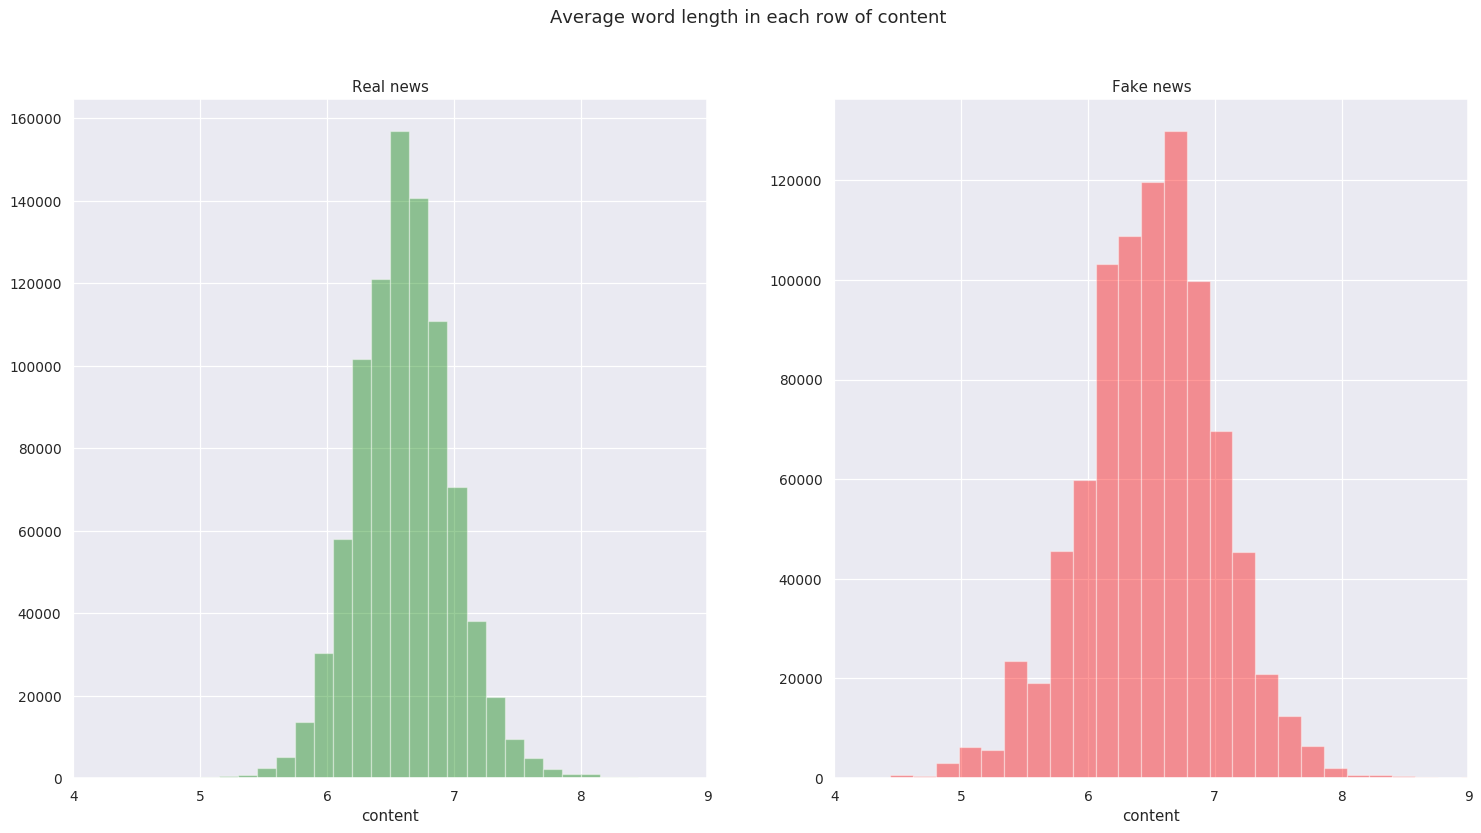

In [98]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['label']=='real']['content'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1, kde=False, color='green')
ax1.set_title('Real news')
ax1.set_xlim((4,9))
word=df[df['label']=='fake']['content'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2, kde=False, color='red')
ax2.set_title('Fake news')
ax2.set_xlim((4,9))
fig.suptitle('Average word length in each row of content')

## Ngram exploration

Ngrams are simply contiguous sequences of n words.


**To build a representation of the vocabulary I use `Countvectorizer`. `Countvectorizer` is
a simple method used to tokenize, vectorize and represent the corpus in an appropriate form.**

In [99]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

In [100]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

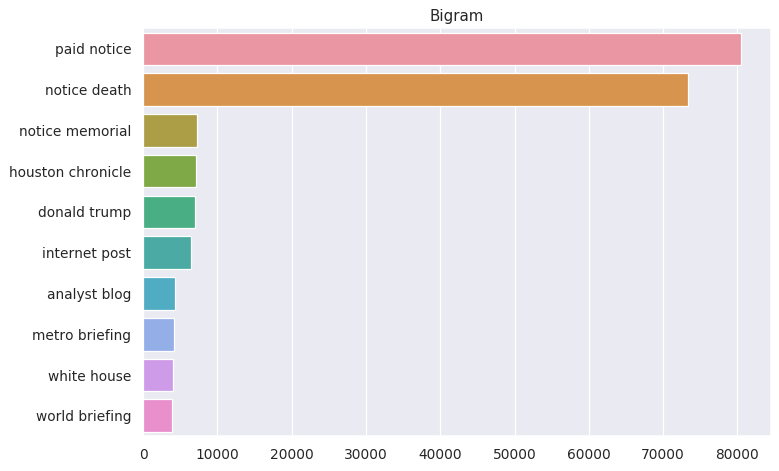

In [101]:
# Top bigrams word in the title
top_n_bigrams=get_top_ngram(df['title'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set_title('Bigram');

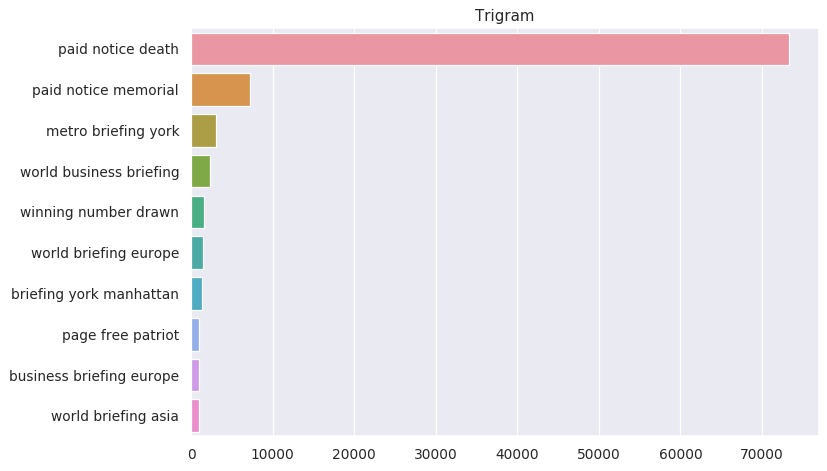

In [102]:
# Top trigrams word in the title
top_n_bigrams=get_top_ngram(df['title'],3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set_title('Trigram');

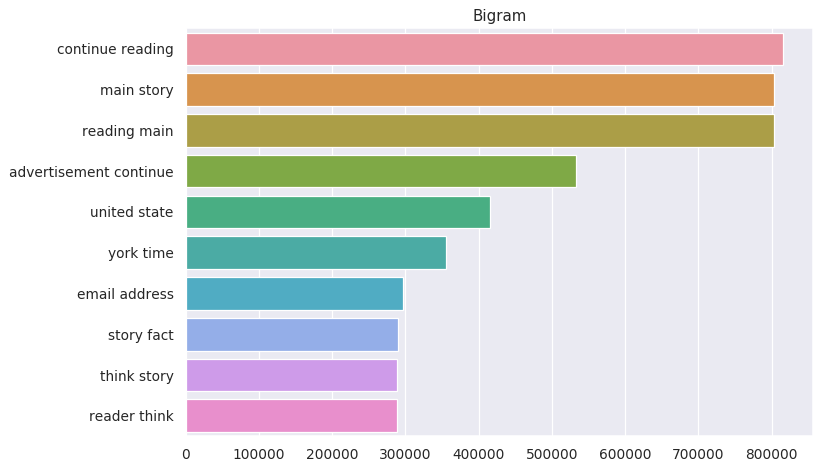

In [103]:
# Top Bigrams in Content column
top_n_bigrams=get_top_ngram(df['content'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set_title('Bigram');

In [104]:
# Top trigrams in content column
top_n_bigrams=get_top_ngram(df['content'],3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set_title('Trigram');

KeyboardInterrupt: 

## Wordcloud

In [105]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [106]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=2000,
        max_font_size=30,
        scale=3,
        random_state=1)
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

#### Word cloud for title text

In [107]:
# Collect all words that appear in the title grouped by real or fake label
real = " ".join(df[df.label == 'real'].title)
fake = " ".join(df[df.label == 'fake'].title)

Wordcloud for title text with the `real` label

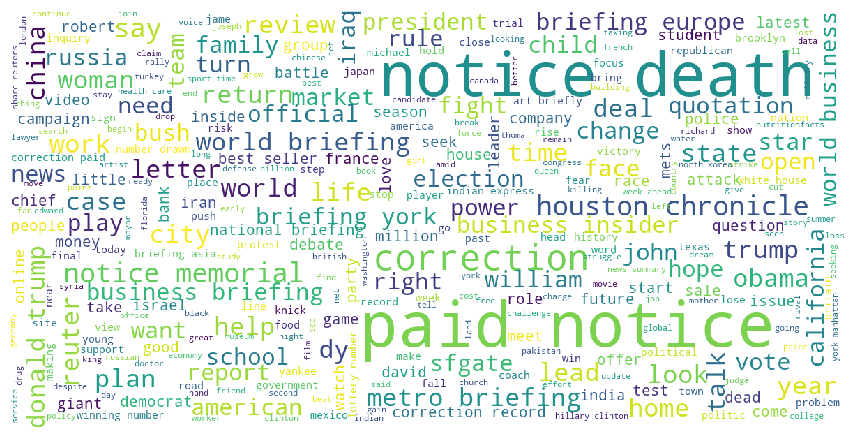

In [108]:
show_wordcloud(real)

Wordcloud for title text with the `fake` label

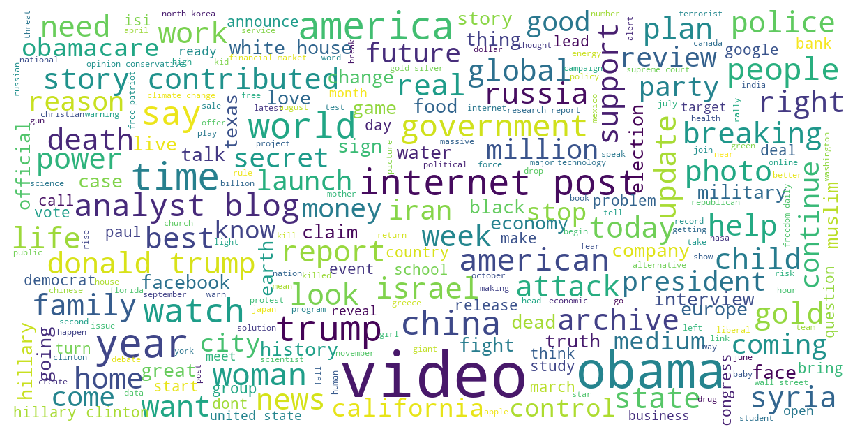

In [109]:
show_wordcloud(fake)

#### Word cloud for content text

In [110]:
# Collect all words that appear in the content grouped by real or fake label
real = " ".join(df[df.label == 'real'].content)
fake = " ".join(df[df.label == 'fake'].content)

Wordcloud for content text with the `real` label

In [ ]:
show_wordcloud(real)

Wordcloud for content text with the `fake` label

In [ ]:
show_wordcloud(fake)